In [165]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

In [99]:
csv_path = os.path.join(os.path.expanduser("~"), "Desktop", "cs_tag_monthly_weekly_daily_with_id.csv")
df = pd.read_csv(csv_path)
df

,period,cs_tag,representative_id,tag_count
0,2022-01-01T00:00:00Z,chat/call_problems,5705J000003o7LKQAY,284
1,2022-01-01T00:00:00Z,contact_data,0101070134IvGAcQAN,198
2,2022-01-01T00:00:00Z,login,0101014423IvDx3QAF,143
3,2022-01-01T00:00:00Z,pos/e_commerce,0101002423IvDViQAN,107
4,2022-01-01T00:00:00Z,chargeback,0101073957IvGbPQAV,61
...,...,...,...,...
10955,2024-12-31T00:00:00Z,account_closure,11200722018XvJHAA0,451
10956,2024-12-31T00:00:00Z,downgrade,1213113145B9VkpAAF,373
10957,2024-12-31T00:00:00Z,phishing,1211180905B008HAAR,317
10958,2024-12-31T00:00:00Z,ct/missing_ct,11251512189WuQEAA0,288


In [100]:
# clean up df['period']
df['period'] = df['period'].str.split('T').str[0]

#lock only values in df that cs_tag == "referral" and cs_tag == "downgrade"
df2 = df[(df['cs_tag'] == 'referral') | (df['cs_tag'] == 'downgrade')]

df2.shape

(325, 4)

In [101]:
df.info() # no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10960 entries, 0 to 10959
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   period             10960 non-null  object
 1   cs_tag             10960 non-null  object
 2   representative_id  10960 non-null  object
 3   tag_count          10960 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 342.6+ KB


In [103]:
tag = df2.groupby('cs_tag').agg({'tag_count':'sum'}).reset_index().sort_values(by = 'tag_count', ascending=False)
tag

,cs_tag,tag_count
0,downgrade,86193
1,referral,7185


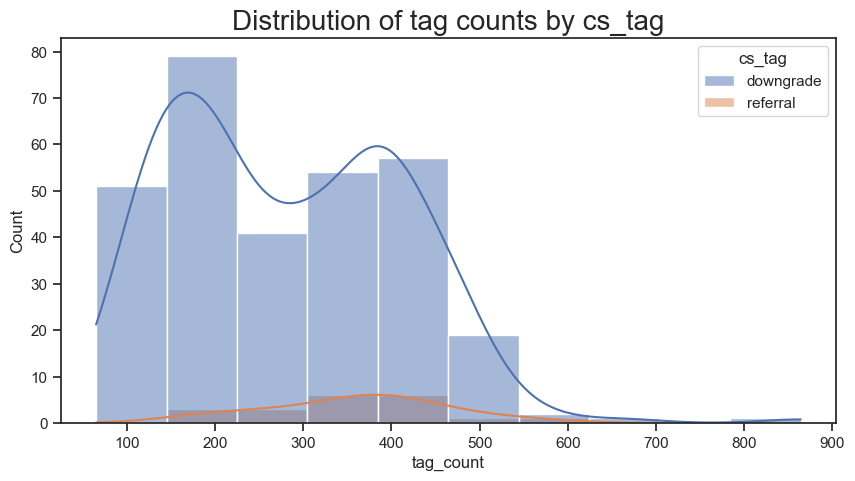

In [104]:
# plot the distribution of cs_tag=="referral" and cs_tag=="downgrade" and chose 2 colors for each group
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 5))
sns.histplot(df2, x='tag_count', hue='cs_tag', kde=True, color='lightblue', bins=10)
plt.title('Distribution of tag counts by cs_tag', size=20)
plt.show()


In [105]:
# checking if the data is normally distributed
from scipy.stats import shapiro

stat, p = shapiro(df['tag_count'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret  
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.843, p=0.000
Sample does not look Gaussian (reject H0)


In [106]:
# Pivot the DataFrame to separate 'cs_tag' into columns 'referral' and 'downgrade'
df2 = df2.pivot(index='period', columns='cs_tag', values='tag_count').reset_index()
df2.columns.name = None  
df2 = df2.fillna(0)      
df2

,period,downgrade,referral
0,2022-03-20,104.0,0.0
1,2022-04-18,169.0,0.0
2,2022-04-23,122.0,0.0
3,2022-04-24,146.0,0.0
4,2022-05-08,128.0,0.0
...,...,...,...
300,2024-12-27,419.0,0.0
301,2024-12-28,247.0,0.0
302,2024-12-29,219.0,0.0
303,2024-12-30,423.0,0.0


In [107]:
sum(df2['referral']) # checking if the sum of the referral column is equal to the number of rows in the original df2

7185.0

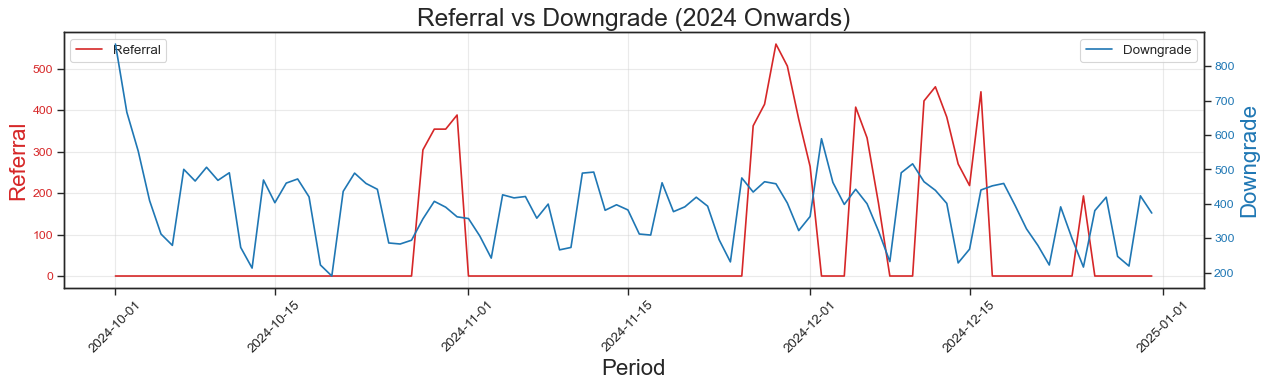

In [111]:
df2['period'] = pd.to_datetime(df2['period'])
df_filtered = df2[df2['period'] >= '2024-10-01']

test = df_filtered[['referral','downgrade']]
test_1 = test.reset_index()

# Prepare the filtered data
x = df_filtered['period']
y1 = df_filtered['referral']
y2 = df_filtered['downgrade']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1, 1, figsize=(16, 5), dpi=80)
ax1.plot(x, y1, color='tab:red', label='Referral')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue', label='Downgrade')

# Decorations for ax1 (left Y axis)
ax1.set_xlabel('Period', fontsize=20)
ax1.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x-axis for readability
ax1.set_ylabel('Referral', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red')
ax1.grid(alpha=.4)

# Decorations for ax2 (right Y axis)
ax2.set_ylabel("Downgrade", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Referral vs Downgrade (2024 Onwards)", fontsize=22)

# Legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Layout adjustments
fig.tight_layout()
plt.show()

### Granger Test

- Null hyptohesis H0 is: A doesn't Granger-cause B
- If p-value < 0.05 Reject H0 -- A granger-causes B
- Shows predicitve power not real world causality

In [112]:
granger_result = grangercausalitytests(test, maxlag=[5], verbose=True)


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2246  , p=0.9508  , df_denom=76, df_num=5
ssr based chi2 test:   chi2=1.2854  , p=0.9364  , df=5
likelihood ratio test: chi2=1.2760  , p=0.9374  , df=5
parameter F test:         F=0.2246  , p=0.9508  , df_denom=76, df_num=5


In [113]:
def grangers_causation_matrix(data, maxlag, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [114]:
grangers_causation_matrix(data=test, maxlag=4, variables = test.columns)  

,referral_x,downgrade_x
referral_y,1.0000,0.4656
downgrade_y,0.0687,1.0000


### Testing for Granger Causality

We look at the lag plots to quickly check for stationarity.

In [123]:
def lag_plots(df2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(df2[df2.columns[1]], ax=ax1)
    ax1.set_title(df2.columns[1]);

    lag_plot(df2[df2.columns[2]], ax=ax2)
    ax2.set_title(df2.columns[2]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

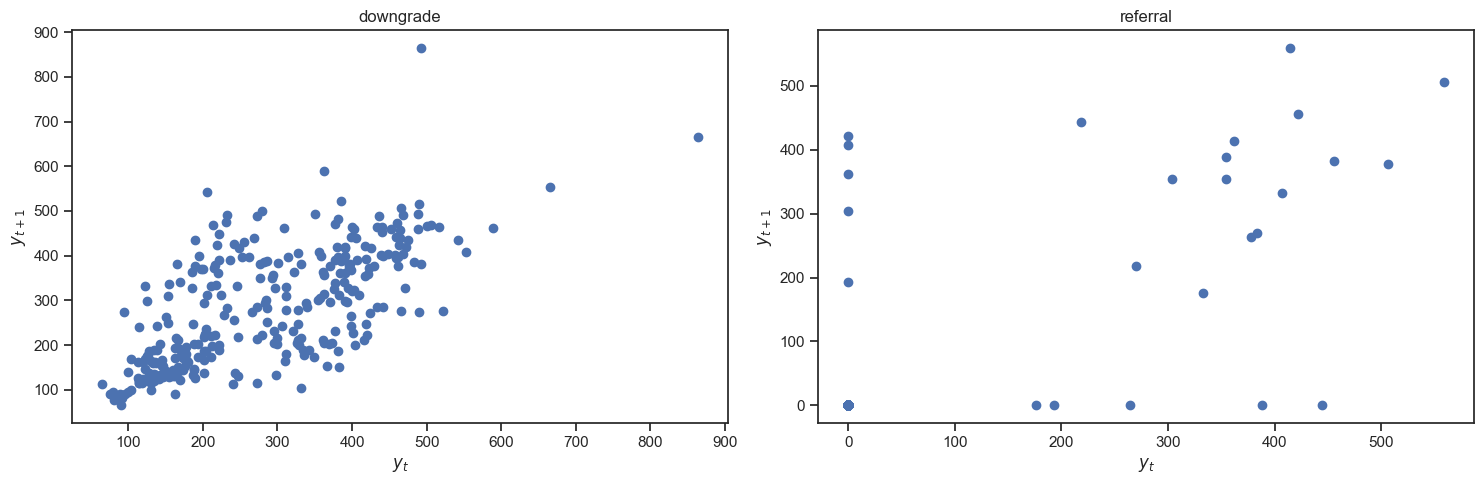

In [124]:
lag_plots(df2)

**Result**: Both columns do not look stationary. Referral lag plot is inconclusive.

We use KPSS and ADF tests discussed in the previous chapter to conclusively check for stationarity.

Hypothesis creation for KPSS and/or ADF tests:
- Null hypothesis H0: The series is stationary.
- Alternative hypothesis H1: The series is not stationary.

>If p-value **< 0.05 we Reject H0**, the series is stationary, otherwise if **p-value > 0.05 we Fail to Reject H0**, the series is not stationary.

In [133]:
def kpss_test(df2):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    
    for c in ['downgrade', 'referral']: 
        kpss_res = kpss(df2[c].dropna(), regression='ct') 
        test_stat.append(kpss_res[0])  
        p_val.append(kpss_res[1])  
        cv_1pct.append(kpss_res[3]['1%'])  
        cv_5pct.append(kpss_res[3]['5%'])  
        cv_10pct.append(kpss_res[3]['10%'])  

    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                                'p-value': p_val, 
                                'Critical value - 1%': cv_1pct,
                                'Critical value - 5%': cv_5pct,
                                'Critical value - 10%': cv_10pct}, 
                                index=['downgrade', 'referral']).T 
    kpss_res_df = kpss_res_df.round(4) 
    return kpss_res_df

In [134]:
kpss_test(df2)

,downgrade,referral
Test statistic,0.2819,0.2121
p-value,0.0100,0.0115
Critical value - 1%,0.2160,0.2160
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


**Result**: Both downgrade and referral are not stationary.

### Augmented Dickey Fuller Test 

In [145]:
def adf_test(df2):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    
    for c in ['downgrade', 'referral']: 
        adf_res = adfuller(df2[c].dropna())  
        test_stat.append(adf_res[0])  
        p_val.append(adf_res[1]) 
        cv_1pct.append(adf_res[4]['1%'])  
        cv_5pct.append(adf_res[4]['5%'])  
        cv_10pct.append(adf_res[4]['10%'])  

    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=['downgrade', 'referral']).T  
    adf_res_df = adf_res_df.round(4)  
    return adf_res_df

In [147]:
adf_test(df2)

,downgrade,referral
Test statistic,-1.4050,-2.4162
p-value,0.5799,0.1372
Critical value - 1%,-3.4530,-3.4533
Critical value - 5%,-2.8715,-2.8716
Critical value - 10%,-2.5721,-2.5721


**Conclusion**: Again the "downgrade" series is non-stationary.

Since both the lag plot and KPSS test indicate that our columns are not stationary, we apply differencing first before building our VAR model.

In [148]:
df2['downgrade'] = df2['downgrade'] - df2['downgrade'].shift(1)
df2 = df2.dropna()

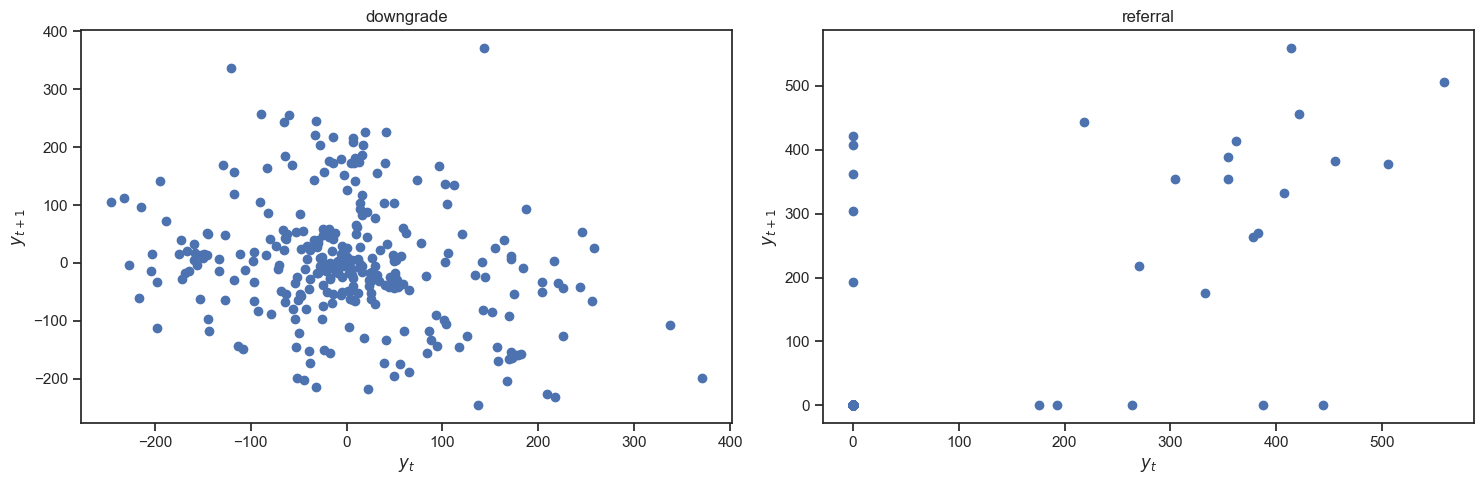

In [149]:
lag_plots(df2)

In [150]:
# checking again for stationarity
kpss_test(df2),  adf_test(df2)

(                      downgrade  referral
 Test statistic           0.0818    0.2113
 p-value                  0.1000    0.0118
 Critical value - 1%      0.2160    0.2160
 Critical value - 5%      0.1460    0.1460
 Critical value - 10%     0.1190    0.1190,
                       downgrade  referral
 Test statistic          -7.7626   -2.4126
 p-value                  0.0000    0.1382
 Critical value - 1%     -3.4530   -3.4533
 Critical value - 5%     -2.8715   -2.8717
 Critical value - 10%    -2.5721   -2.5722)

* Both tests (KPSS and ADF) are consistent in their results here, suggesting the "downgrade" series is stationary:
* KPSS suggests the series is stationary (p-value = 0.1000, fail to reject null).
* ADF suggests the series is stationary (p-value = 0.0000, reject null of unit root).
> Conclusion: The "downgrade" series is stationary after first differencing.


In [151]:
# since column referall is stationary, we can proceed with building the VAR model.
df2['referral'] = df2['referral'] - df2['referral'].shift(1)
df2 = df2.dropna()

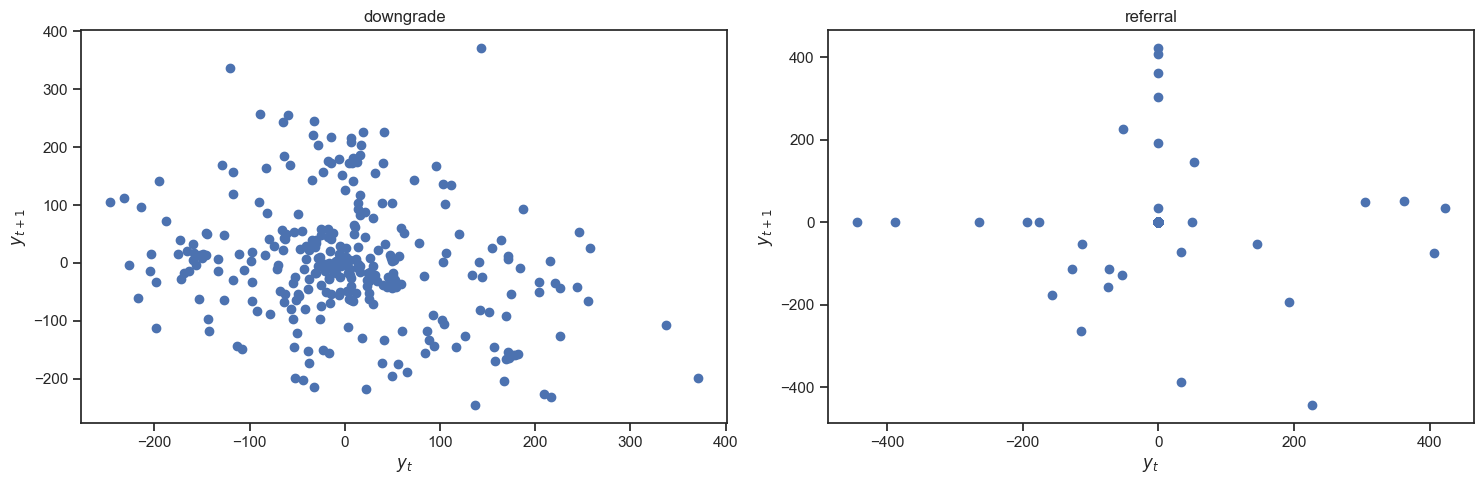

In [152]:
lag_plots(df2)

In [153]:
# checking again for stationarity
kpss_test(df2),  adf_test(df2)

(                      downgrade  referral
 Test statistic           0.0895    0.0358
 p-value                  0.1000    0.1000
 Critical value - 1%      0.2160    0.2160
 Critical value - 5%      0.1460    0.1460
 Critical value - 10%     0.1190    0.1190,
                       downgrade  referral
 Test statistic          -7.7472   -5.3574
 p-value                  0.0000    0.0000
 Critical value - 1%     -3.4531   -3.4534
 Critical value - 5%     -2.8716   -2.8717
 Critical value - 10%    -2.5721   -2.5722)

- After first differencing, both the "downgrade" and "referral" series are found to be stationary by both the KPSS and ADF tests, as both tests indicate stationarity with p-values indicating rejection of the null hypothesis for a unit root (ADF test) and failure to reject the null hypothesis for stationarity (KPSS test).

#### We next split the data into train and test sets for the VAR model

In [154]:
def splitter(df2):
    end = round(len(df2)*.8)
    train_df = df2[:end]
    test_df = df2[end:]
    return train_df, test_df

In [157]:
train_df, test_df = splitter(df2)

In [161]:
train_df

,period,downgrade,referral
2,2022-04-23,-47.0,0.0
3,2022-04-24,24.0,0.0
4,2022-05-08,-18.0,0.0
5,2022-05-15,59.0,0.0
6,2022-05-30,60.0,0.0
...,...,...,...
239,2024-10-27,11.0,0.0
240,2024-10-28,62.0,304.0
241,2024-10-29,51.0,50.0
242,2024-10-30,-17.0,0.0


We then select the VAR order 𝑝 by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [162]:

def select_p(train_df):
    train_df = train_df.dropna()

    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df)
    
    # Limit the lag range based on your dataset size
    p = np.arange(1, 21)  # Try smaller lag range for 242 rows

    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)

    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    plt.show()


    print("Optimal lag based on AIC, BIC, FPE, and HQIC:")
    print(lags_metrics_df.idxmin(axis=0))

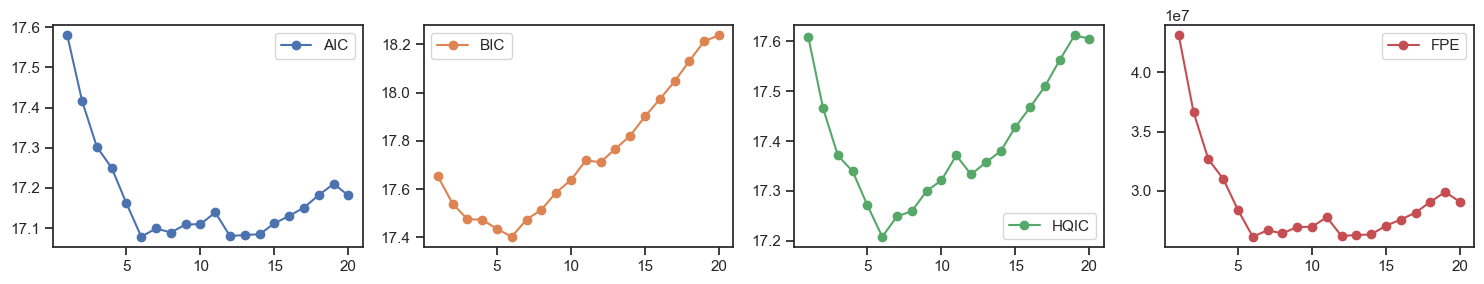

Optimal lag based on AIC, BIC, FPE, and HQIC:
AIC     6
BIC     6
HQIC    6
FPE     6
dtype: int64


In [ ]:

select_p(df2[['downgrade', 'referral']])

**Interpretation**:

* AIC (Akaike Information Criterion):
AIC is used to compare models while penalizing for the number of parameters. The model with the lowest AIC is generally considered the best fit, as it balances model fit and complexity.

* BIC (Bayesian Information Criterion):
BIC is another model selection criterion similar to AIC but with a stronger penalty for models with more parameters. Like AIC, the model with the lowest BIC is preferred.

* HQIC (Hannan-Quinn Information Criterion):
HQIC is another information criterion used for model comparison. It also penalizes model complexity but with a different weighting compared to AIC and BIC. Like the other criteria, lower values indicate better-fitting models.

* FPE (Final Prediction Error):
The lower the FPE, the better the model's predictive performance.



> All four criteria (AIC, BIC, HQIC, FPE) suggest that lag 6 is the optimal lag for fitting the VAR model. This means that For each time series the model will use the data from the past **6 time periods ** to estimate the relationships and predict the current variables.

In [ ]:
# We now fit the VAR model with the chosen order.
p = 6
model = VAR(df2[['downgrade', 'referral']].dropna())
results = model.fit(p)

In [174]:
def granger_causation_matrix(data, variables, p, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [175]:
variables = ['downgrade', 'referral']
p = 6  
granger_result = granger_causation_matrix(df2[['downgrade', 'referral']].dropna(), variables, p)
granger_result

,downgrade_x,referral_x
downgrade_y,1.000,0.0502
referral_y,0.547,1.0000


Recall: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

downgrade_y -> referral_x: >> We can interpret this as a **weak** indication that referral might have a causal influence on downgrade, but due to the p-value being so close to 0.05, this result is not conclusive.

referral_y -> downgrade_x: >> The p-value is 0.5470. This is much larger than 0.05, meaning there is no Granger causality from downgrade to referral. Referral might have some causal influence on downgrade, but it is a weak causal relationship.
